In [2]:
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, r2_score

import pysindy as ps

import math

import copy

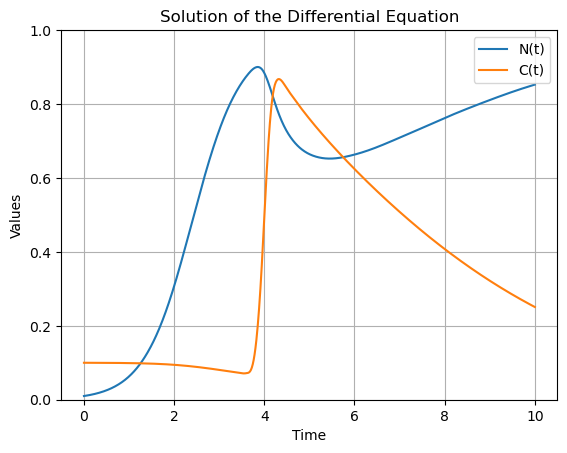

Features (21): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3', 'x1^4', 'x0^5', 'x0^4 x1', 'x0^3 x1^2', 'x0^2 x1^3', 'x0 x1^4', 'x1^5']
(N)' = 2.014 N + -1.768 N^2 + -1.376 N C + -1.033 N^3 + 0.515 N^2 C + 0.278 N C^2 + 1.442 N^4 + -0.168 N C^3 + 0.046 C^4 + -0.676 N^5 + -0.889 N^3 C^2 + 1.149 N^2 C^3 + -0.710 N C^4 + 0.108 C^5
(C)' = -3591.450 1 + 12057.484 N + 42834.357 C + -12784.252 N^2 + -136189.018 N C + -73533.037 C^2 + 3290.172 N^3 + 133685.174 N^2 C + 212460.464 N C^2 + 39238.204 C^3 + 1350.050 N^4 + -29897.900 N^3 C + -192296.939 N^2 C^2 + -87722.406 N C^3 + -5127.279 C^4 + -320.829 N^5 + -10276.572 N^4 C + 52128.034 N^3 C^2 + 49686.422 N^2 C^3 + 4148.177 N C^4 + 982.663 C^5
Model score: 0.995242


In [ ]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return N

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
#setting this higher seems make the symbolic regression worse counter intuativly. If the problem is caused by errors in derivative calculations increasing the point density should mitigate it.
numevals = 1000
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.1],t_eval=evalpts,args=(trueAlpha,))

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

X = np.stack((solution.y[0],solution.y[1]),axis=-1)

# Figure out how many library features there will be
library = ps.PolynomialLibrary(degree=5)
library.fit([ps.AxesArray(X, {"ax_sample": 1, "ax_coord": 2})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, max_iter=10000)

model =ps.SINDy(feature_names=["N","C"],feature_library=library, optimizer=optimizer)
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

In [10]:
model =ps.SINDy(feature_names=["N","C"])
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

(N)' = 2.002 N + -2.003 N^2 + -1.000 N C
(C)' = 0.725 1 + -2.021 N + -6.474 C + 1.377 N^2 + 8.446 N C + 0.704 C^2
Model score: 0.675911


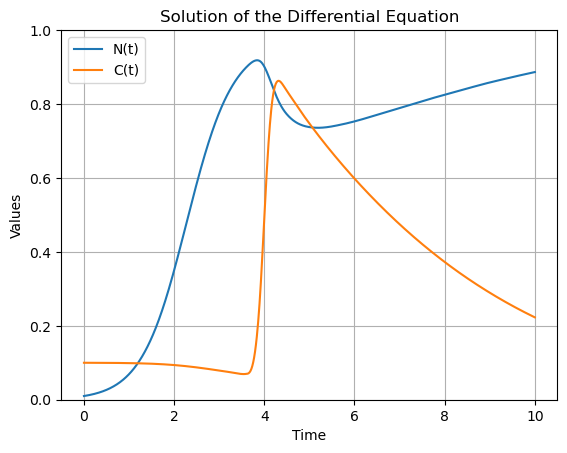

Features (21): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3', 'x1^4', 'x0^5', 'x0^4 x1', 'x0^3 x1^2', 'x0^2 x1^3', 'x0 x1^4', 'x1^5']
(N)' = 36.825 N + -31.616 C + -92.006 N^2 + -300.135 N C + 347.700 C^2 + 72.168 N^3 + 849.344 N^2 C + -485.363 N C^2 + -327.840 C^3 + -15.455 N^4 + -653.680 N^3 C + 477.226 N C^3 + 93.784 C^4 + -1.465 N^5 + 134.914 N^4 C + 130.524 N^3 C^2 + -141.621 N^2 C^3 + -92.470 N C^4 + -2.838 C^5
(C)' = -1167.620 1 + -515.324 N + 16461.072 C + 9523.363 N^2 + -3536.886 N C + -51848.281 C^2 + -13269.080 N^3 + -87335.652 N^2 C + 104318.429 N C^2 + 39793.057 C^3 + 5863.962 N^4 + 118355.019 N^3 C + -49262.696 N^2 C^2 + -70518.027 N C^3 + -8612.115 C^4 + -436.101 N^5 + -43883.861 N^4 C + -3207.604 N^3 C^2 + 30141.633 N^2 C^3 + 8442.558 N C^4 + 394.603 C^5
Model score: 0.988046


In [14]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return N**2

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
#setting this higher seems make the symbolic regression worse counter intuativly. If the problem is caused by errors in derivative calculations increasing the point density should mitigate it.
numevals = 1000
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.1],t_eval=evalpts,args=(trueAlpha,))

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

X = np.stack((solution.y[0],solution.y[1]),axis=-1)

# Figure out how many library features there will be
library = ps.PolynomialLibrary(degree=5)
library.fit([ps.AxesArray(X, {"ax_sample": 1, "ax_coord": 2})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, max_iter=10000)#, tol=1e-8)

model =ps.SINDy(feature_names=["N","C"],feature_library=library, optimizer=optimizer)
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

In [13]:
model =ps.SINDy(feature_names=["N","C"])
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

(N)' = 2.089 N + 0.099 C + -2.125 N^2 + -0.893 N C
(C)' = 1.369 1 + -2.459 N + -13.282 C + 0.953 N^2 + 15.821 N C + 1.412 C^2
Model score: 0.692353


Specifying the degree of the polynomial solves the problem

In [ ]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary(degree=3)
library.fit([ps.AxesArray(X, {"ax_sample": 1, "ax_coord": 2})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, max_iter=10000)

model =ps.SINDy(feature_names=["N","C"],feature_library=library, optimizer=optimizer)
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

Features (10): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
(N)' = 2.002 N + -2.003 N^2 + -0.999 N^2 C
(C)' = 7.434 1 + -5.330 N + -87.822 C + -7.306 N^2 + 68.720 N C + 133.481 C^2 + 5.375 N^3 + 19.927 N^2 C + -96.601 N C^2 + -40.477 C^3
Model score: 0.920187


My SINDy implementation seems to work if i specify the exact degree of the differential equation multinomial of N. If the degree is set too high, the algorithm seems to overfit to the data somehow. I don't understand why this is happening as the ideal approximation should be the correct one thus overfitting should not be a problem.

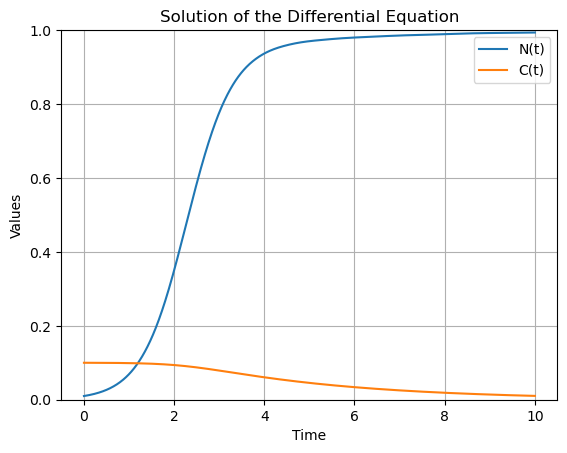

Features (21): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3', 'x1^4', 'x0^5', 'x0^4 x1', 'x0^3 x1^2', 'x0^2 x1^3', 'x0 x1^4', 'x1^5']
(N)' = 25.600 N + -87.436 N^2 + -518.005 N C + 101.770 N^3 + 1310.892 N^2 C + 2818.065 N C^2 + -42.047 N^4 + -1129.438 N^3 C + -4494.871 N^2 C^2 + 2.106 N^5 + 336.927 N^4 C + 1669.474 N^3 C^2
(C)' = -0.300 N C
Model score: 0.999988


In [16]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)]#+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return N**2

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
#setting this higher seems make the symbolic regression worse counter intuativly. If the problem is caused by errors in derivative calculations increasing the point density should mitigate it.
numevals = 1000
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.1],t_eval=evalpts,args=(trueAlpha,))

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

X = np.stack((solution.y[0],solution.y[1]),axis=-1)

# Figure out how many library features there will be
library = ps.PolynomialLibrary(degree=5)
library.fit([ps.AxesArray(X, {"ax_sample": 1, "ax_coord": 2})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, max_iter=10000)#, tol=1e-8)

model =ps.SINDy(feature_names=["N","C"],feature_library=library, optimizer=optimizer)
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

It seems that the problem is not caused by the complicated form of C because when the injection is removed, we get the same behavior with N.

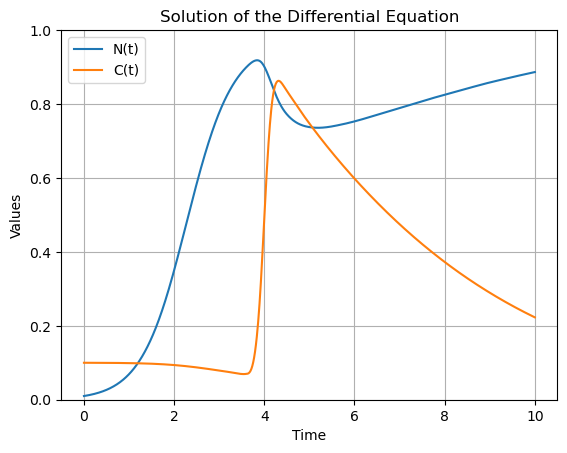

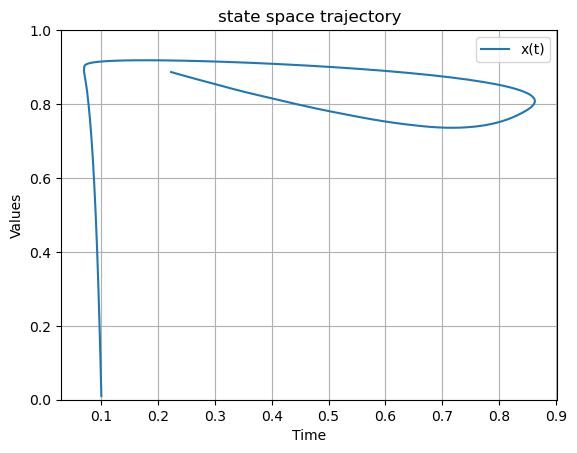

Features (66): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3', 'x0^4', 'x0^3 x1', 'x0^2 x1^2', 'x0 x1^3', 'x1^4', 'x0^5', 'x0^4 x1', 'x0^3 x1^2', 'x0^2 x1^3', 'x0 x1^4', 'x1^5', 'x0^6', 'x0^5 x1', 'x0^4 x1^2', 'x0^3 x1^3', 'x0^2 x1^4', 'x0 x1^5', 'x1^6', 'x0^7', 'x0^6 x1', 'x0^5 x1^2', 'x0^4 x1^3', 'x0^3 x1^4', 'x0^2 x1^5', 'x0 x1^6', 'x1^7', 'x0^8', 'x0^7 x1', 'x0^6 x1^2', 'x0^5 x1^3', 'x0^4 x1^4', 'x0^3 x1^5', 'x0^2 x1^6', 'x0 x1^7', 'x1^8', 'x0^9', 'x0^8 x1', 'x0^7 x1^2', 'x0^6 x1^3', 'x0^5 x1^4', 'x0^4 x1^5', 'x0^3 x1^6', 'x0^2 x1^7', 'x0 x1^8', 'x1^9', 'x0^10', 'x0^9 x1', 'x0^8 x1^2', 'x0^7 x1^3', 'x0^6 x1^4', 'x0^5 x1^5', 'x0^4 x1^6', 'x0^3 x1^7', 'x0^2 x1^8', 'x0 x1^9', 'x1^10']
(N)' = -250.798 N + 786.199 N^2 + 2509.766 N C + -190.379 N^3 + -7234.317 N^2 C + -41.238 C^3 + -2624.067 N^5 + 2306.444 N^4 C + -14734.527 N^2 C^3 + 22527.337 N C^4 + 6897.564 N^6 + 6668.309 N^5 C + -65408.111 N^2 C^4 + -94308.635 N C^5 + 47103.740 C^6 + -16655.679 N^7 +

In [49]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return N**2

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
#setting this higher seems make the symbolic regression worse counter intuativly. If the problem is caused by errors in derivative calculations increasing the point density should mitigate it.
numevals = 1000
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(initial,final),[0.01,0.1],t_eval=evalpts,args=(trueAlpha,))

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(solution.y[1], solution.y[0], label='x(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('state space trajectory')
plt.legend()
plt.grid(True)
plt.show()

X = np.stack((solution.y[0],solution.y[1]),axis=-1)

# Figure out how many library features there will be
library = ps.PolynomialLibrary(degree=10)
library.fit([ps.AxesArray(X, {"ax_sample": 1, "ax_coord": 2})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, max_iter=10000)#, tol=1e-8)

model =ps.SINDy(feature_names=["N","C"],feature_library=library, optimizer=optimizer)
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

In [54]:
trueAlpha = 2
final = 10
initial = 0
#setting this higher seems make the symbolic regression worse counter intuativly. If the problem is caused by errors in derivative calculations increasing the point density should mitigate it.
numevals = 100000
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(initial,final),[0.01,0.1],t_eval=evalpts,args=(trueAlpha,))

X = np.stack((solution.y[0],solution.y[1]),axis=-1)

# Figure out how many library features there will be
library = ps.PolynomialLibrary(degree=3)
library.fit([ps.AxesArray(X, {"ax_sample": 1, "ax_coord": 2})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, max_iter=10000)#, tol=1e-8)

model =ps.SINDy(feature_names=["N","C"],feature_library=library, optimizer=optimizer)
model.fit(X,t=solution.t,)

model.print()

# Compare SINDy-predicted derivatives with finite difference derivatives
print("Model score: %f" % model.score(X, t=solution.t))

Features (10): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
(N)' = 2.002 N + -2.003 N^2 + -0.999 N^2 C
(C)' = 7.428 1 + -5.302 N + -87.766 C + -7.337 N^2 + 68.493 N C + 133.567 C^2 + 5.383 N^3 + 20.117 N^2 C + -96.693 N C^2 + -40.488 C^3
Model score: 0.920322


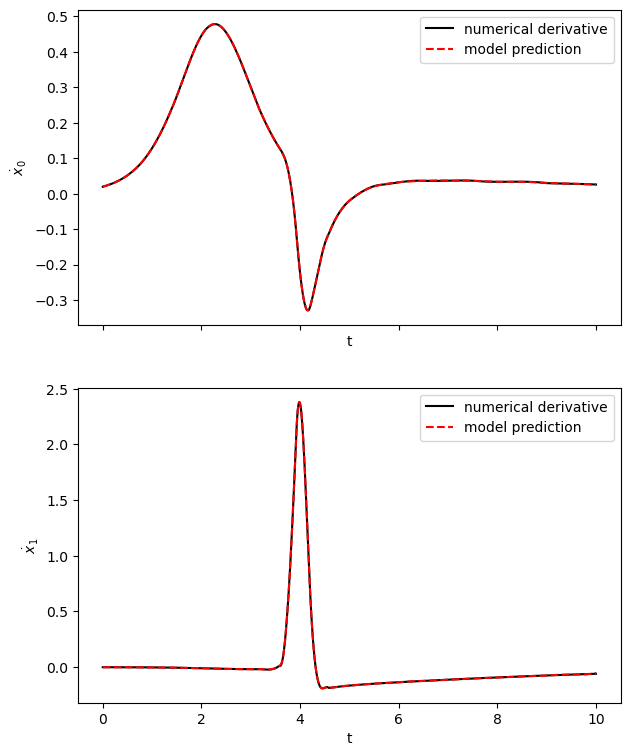

In [38]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(X)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(X, t=solution.t)

fig, axs = plt.subplots(X.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
fig.show()

including the true value of the derivative solves the problem. That implies that our issue was that the model was fitting to the errors introduced by the default finite diffrence approximator for the derivative.

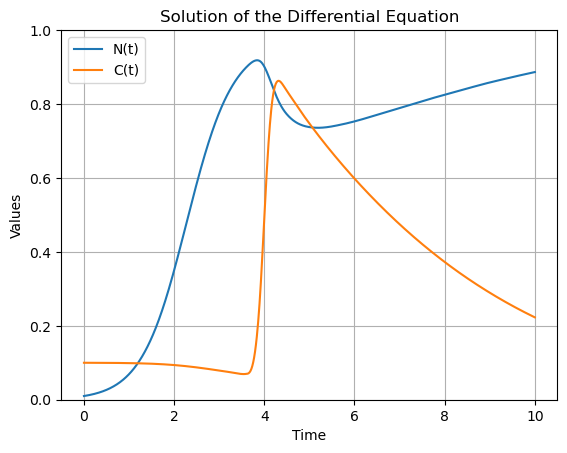

model with C' as a feature:
(x0)' = 2.000 x0 + -2.000 x0^2 + -1.000 x0^2 x1
(x1)' = 1.000 C'
Model score: 0.999820
model without C' as a feature:
(x0)' = 2.000 x0 + -2.000 x0^2 + -1.000 x0^2 x1
(x1)' = 2724.233 1 + -2628.098 x0 + -26571.155 x1 + -2327.627 u0 + 2858.413 x0^2 + 28473.741 x0 x1 + 1794.381 x0 u0 + -9642.606 x1^2 + 23582.719 x1 u0 + 520.977 u0^2 + 1866.913 x0^3 + -6038.866 x0^2 x1 + -2979.235 x0^2 u0 + -5233.594 x0 x1^2 + -24870.412 x0 x1 u0 + -10.519 x0 u0^2 + 28192.397 x1^3 + -2815.943 x1^2 u0 + -5367.643 x1 u0^2 + -30.162 u0^3 + -2324.788 x0^4 + -42409.907 x0^3 x1 + 1629.943 x0^3 u0 + 38538.327 x0^2 x1^2 + 20501.991 x0^2 x1 u0 + 264.696 x0^2 u0^2 + -15275.787 x0 x1^3 + -3625.887 x0 x1^2 u0 + 3607.925 x0 x1 u0^2 + -95.581 x0 u0^3 + -6544.535 x1^4 + -7700.495 x1^3 u0 + 2173.630 x1^2 u0^2 + 339.401 x1 u0^3 + 5.036 u0^4 + -1176.759 x0^5 + 9008.448 x0^4 x1 + 1251.025 x0^4 u0 + 996.179 x0^3 x1^2 + 5072.714 x0^3 x1 u0 + -712.342 x0^3 u0^2 + -12406.262 x0^2 x1^3 + -7316.605 x0^2

In [151]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return N**2

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

# Solve the system
trueAlpha = 2
t_eval = np.linspace(0, 10, 1000)
solution = solve_ivp(lambda t, y: fprime(t, y, trueAlpha), [0, 10], [0.01, 0.1], t_eval=t_eval)

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

X = solution.y.T  # shape (1000, 2)
t = solution.t    # shape (1000,)
U = t.reshape(-1, 1)  # u(t) = time

# Define custom feature using both state and time (via u)
def custom_feature(N, C, t):
    return cprime(N,C)+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)


custom_lib = ps.CustomLibrary(
    library_functions=[custom_feature],
    function_names=[lambda x0, x1, u:"C'"]
)
print("model with C' as a feature:")
# Combine with a polynomial library if desired
poly_lib = ps.PolynomialLibrary(degree=5)
combined = ps.GeneralizedLibrary([poly_lib, custom_lib])

optimizer = ps.STLSQ(threshold=0.01, alpha=1e-6, max_iter=10000)

# Fit model with control variable u = t
model = ps.SINDy(feature_library=combined,optimizer=optimizer)
x_dot = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])+ injectionStrength*np.exp(-(injectionSpeed*(solution.t-4))**2)]).T
model.fit(X, u=U, t=t,x_dot=x_dot )
model.print()
print("Model score: %f" % model.score(X,u=U, t=solution.t))


print("model without C' as a feature:")
optimizer = ps.STLSQ(threshold=0.01, alpha=1e-6, max_iter=10000)

# Fit model with control variable u = t
model = ps.SINDy(feature_library=poly_lib,optimizer=optimizer)
x_dot = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])+ injectionStrength*np.exp(-(injectionSpeed*(solution.t-4))**2)]).T
model.fit(X, u=U, t=t,x_dot=x_dot )
model.print()
print("Model score: %f" % model.score(X,u=U, t=solution.t))



We thus try alternative methods of differentiation.

In [86]:
model = ps.SINDy(
    differentiation_method=ps.SmoothedFiniteDifference(),
    feature_library=combined,
    optimizer=optimizer
)
model.fit(X, u=U, t=t)
model.print()

(x0)' = -595.822 1 + 629.158 x0 + 8201.577 x1 + 652.202 u0 + -8098.536 x0 x1 + -1086.875 x0 u0 + -23839.519 x1^2 + -7386.335 x1 u0 + -139.276 u0^2 + 604.838 x0^3 + -1637.581 x0^2 x1 + 160.242 x0^2 u0 + 26454.813 x0 x1^2 + 11010.618 x0 x1 u0 + 297.527 x0 u0^2 + 13536.454 x1^3 + 8823.025 x1^2 u0 + 1509.991 x1 u0^2 + -778.499 x0^4 + -4923.774 x0^3 x1 + 325.628 x0^3 u0 + 5620.526 x0^2 x1^2 + -317.205 x0^2 x1 u0 + -168.523 x0^2 u0^2 + -25112.578 x0 x1^3 + -8745.104 x0 x1^2 u0 + -2961.247 x0 x1 u0^2 + -0.247 x0 u0^3 + -367.577 x1^4 + -1016.249 x1^3 u0 + -1221.796 x1^2 u0^2 + 35.048 x0^5 + 6975.028 x0^4 x1 + -6968.261 x0^3 x1^2 + -3502.633 x0^3 x1 u0 + 2.596 x0^3 u0^2 + 15351.970 x0^2 x1^3 + -1243.737 x0^2 x1^2 u0 + 1469.643 x0^2 x1 u0^2 + 0.538 x0^2 u0^3 + 688.357 x0 x1^4 + -666.343 x0 x1^3 u0 + 1487.674 x0 x1^2 u0^2 + 127.779 x1^5 + -77.679 x1^4 u0 + 186.326 x1^3 u0^2 + -16.069 x1^2 u0^3 + 0.032 C'
(x1)' = -562.392 1 + 688.568 x0 + 6963.174 x1 + -631.954 u0 + -5880.290 x0^2 + -13206.124 x0 

In [103]:
trueAlpha = 2
final = 10
initial = 0
#setting this higher seems make the symbolic regression worse counter intuativly. If the problem is caused by errors in derivative calculations increasing the point density should mitigate it.
numevals = 1000000
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(initial,final),[0.01,0.1],t_eval=evalpts,args=(trueAlpha,))

X = solution.y.T  # shape (1000, 2)
t = solution.t    # shape (1000,)
U = t.reshape(-1, 1)  # u(t) = time

print("model with C' as a feature:")
# Combine with a polynomial library if desired
poly_lib = ps.PolynomialLibrary(degree=4)
combined = ps.GeneralizedLibrary([poly_lib, custom_lib])

model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-2),
    feature_library=combined,
    optimizer=optimizer
)
model.fit(X, u=U, t=t)
model.print()

model with C' as a feature:
(x0)' = 37.836 1 + -21.988 x0 + -405.907 x1 + -37.242 u0 + 109.234 x0^2 + 398.398 x0 x1 + 29.550 x0 u0 + 254.917 x1^2 + 407.076 x1 u0 + 1.668 u0^2 + -116.120 x0^3 + -581.623 x0^2 x1 + -19.220 x0^2 u0 + 1067.936 x0 x1^2 + -536.857 x0 x1 u0 + 3.291 x0 u0^2 + -57.216 x1^3 + -398.951 x1^2 u0 + -18.201 x1 u0^2 + -0.094 u0^3 + -30.539 x0^4 + 781.933 x0^3 x1 + 38.013 x0^3 u0 + -1309.339 x0^2 x1^2 + 59.728 x0^2 x1 u0 + -6.628 x0^2 u0^2 + -164.823 x0 x1^3 + 384.198 x0 x1^2 u0 + 25.359 x0 x1 u0^2 + 0.160 x0 u0^3 + -28.346 x1^4 + 59.737 x1^3 u0 + 3.050 x1^2 u0^2 + -0.209 x1 u0^3 + -0.162 C'
(x1)' = -70.345 1 + 92.821 x0 + 783.436 x1 + 53.841 u0 + 348.781 x0^2 + 234.287 x0 x1 + -91.282 x0 u0 + -943.787 x1^2 + -624.540 x1 u0 + -12.264 u0^2 + 3.303 x0^3 + 1029.625 x0^2 x1 + -240.199 x0^2 u0 + -1653.917 x0 x1^2 + -252.092 x0 x1 u0 + 33.182 x0 u0^2 + 387.763 x1^3 + 797.711 x1^2 u0 + 130.800 x1 u0^2 + 0.451 u0^3 + -269.539 x0^4 + -936.516 x0^3 x1 + 239.844 x0^3 u0 + -214.850

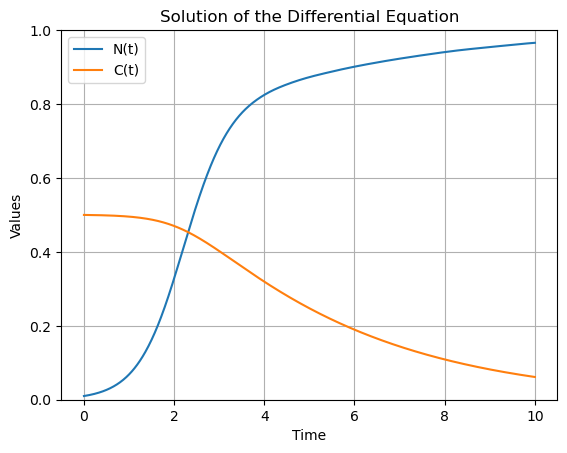

(x0)' = 2.000 x0 + -2.000 x0^2 + -1.000 x0^2 x1
(x1)' = -0.300 x0 x1


In [160]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)]#+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return N**2

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

# Solve the system
trueAlpha = 2
t_eval = np.linspace(0, 10, 1000)
solution = solve_ivp(lambda t, y: fprime(t, y, trueAlpha), [0, 10], [0.01, 0.5], t_eval=t_eval)

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

X = solution.y.T  # shape (1000, 2)
t = solution.t    # shape (1000,)
U = t.reshape(-1, 1)  # u(t) = time

# Define custom feature using both state and time (via u)
def custom_feature(N, C, t):
    return cprime(N,C)#+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)


custom_lib = ps.CustomLibrary(
    library_functions=[custom_feature],
    function_names=[lambda x0, x1, u:"C'"]
)
# Combine with a polynomial library if desired
poly_lib = ps.PolynomialLibrary(degree=5)
combined = ps.GeneralizedLibrary([poly_lib, custom_lib])

optimizer = ps.STLSQ(threshold=0.02, alpha=1e-6, max_iter=10000)

# Fit model with control variable u = t
model = ps.SINDy(feature_library=combined,optimizer=optimizer)
x_dot = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T
model.fit(X, u=U, t=t,x_dot=x_dot )
model.print()



Uniqueness conditions not met and we still get the correct answer. Hypothesis: The reson SINDy is able to retrieve the correct answer in this case is it's sparcity assumption. To test this, we will make the the drug action more complicated and see if it can still get it correct.

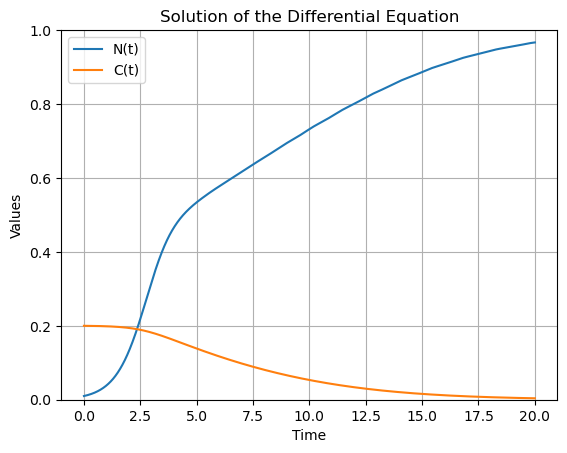

(x0)' = 2.000 x0 + -2.000 x0^2 + -3.000 x0 x1 + -1.000 x0^2 x1 + -7.000 x0^3 x1 + -2.000 x0^4 x1 + -2.500 x0^5 x1 + -0.700 x0^6 x1
(x1)' = -0.300 x0 x1
Model score: 0.999371


In [237]:

def u(N):
  return 3*N + N**2 + 7*N**3 +2*N**4 +2.5*N**5 +0.7*N**6
'''
def u(N):
  return N**2
'''
injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)]#+ injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

# Solve the system
trueAlpha = 2
t_eval = np.linspace(0, 20, 5000)
solution = solve_ivp(lambda t, y: fprime(t, y, trueAlpha), [0, 20], [0.01, 0.2], t_eval=t_eval)

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

X = solution.y.T  # shape (1000, 2)
t = solution.t    # shape (1000,)

# Combine with a polynomial library if desired
poly_lib = ps.PolynomialLibrary(degree=10)

optimizer = ps.STLSQ(threshold=0.05, alpha=1e-4, max_iter=10000)

# Fit model with control variable u = t
model = ps.SINDy(feature_library=poly_lib,optimizer=optimizer)
x_dot = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T
model.fit(X, t=t,x_dot=x_dot )
model.print()
print("Model score: %f" % model.score(X, t=solution.t))



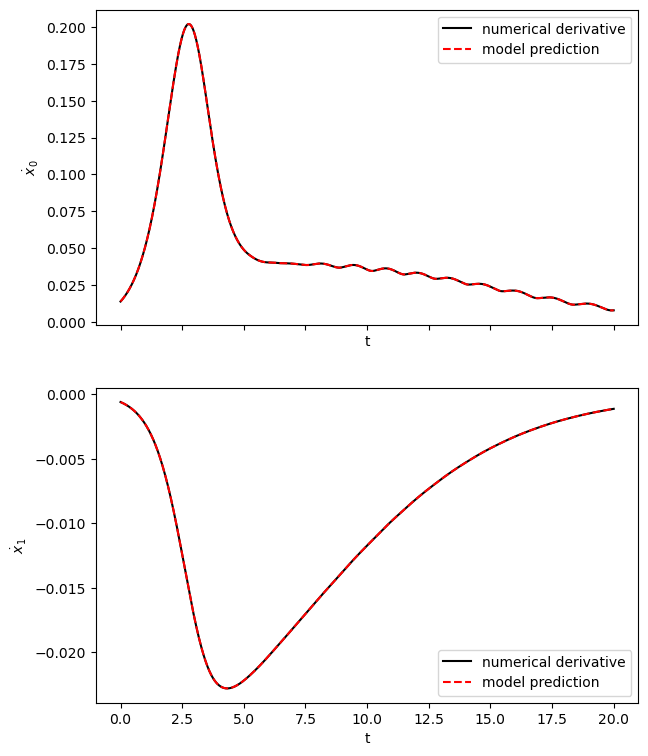

In [238]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(X)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = x_dot

fig, axs = plt.subplots(X.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
fig.show()

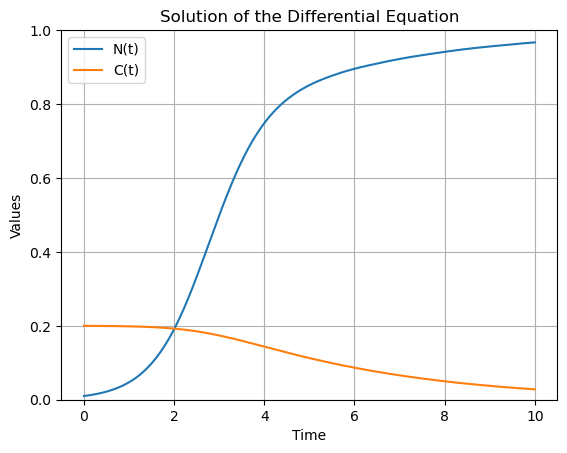

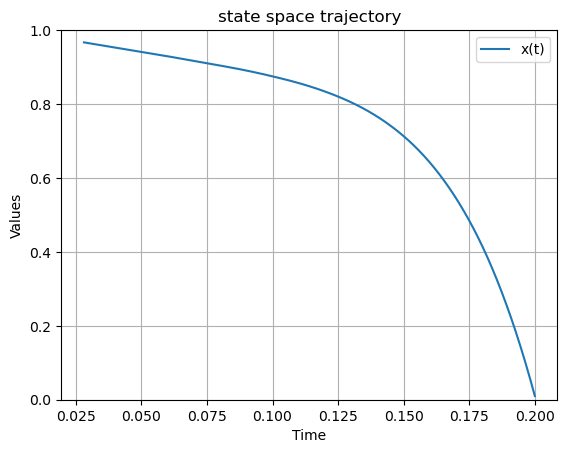

In [35]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)]# + injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return 2*N

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
numevals = 2**16
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.2],t_eval=evalpts,args=(trueAlpha,))

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(solution.y[1], solution.y[0], label='x(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('state space trajectory')
plt.legend()
plt.grid(True)
plt.show()

65536 data points
(N)' = 62.543 N + -14.153 N^2 + -304.025 N C
(C)' = 0.000
Model score: -2.129187


c:\Users\shale\miniconda3\envs\PINNsAndUPINNs\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


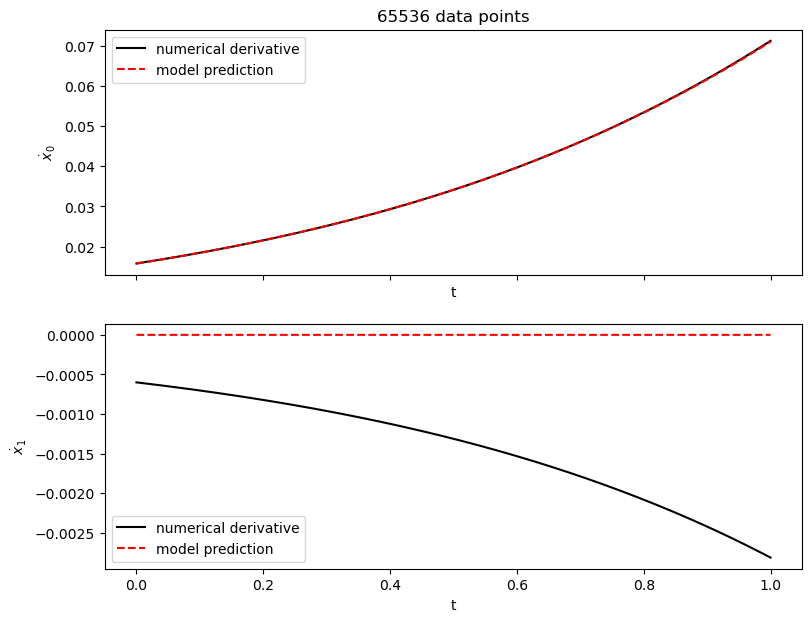

In [34]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [0]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.01, alpha=50)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()

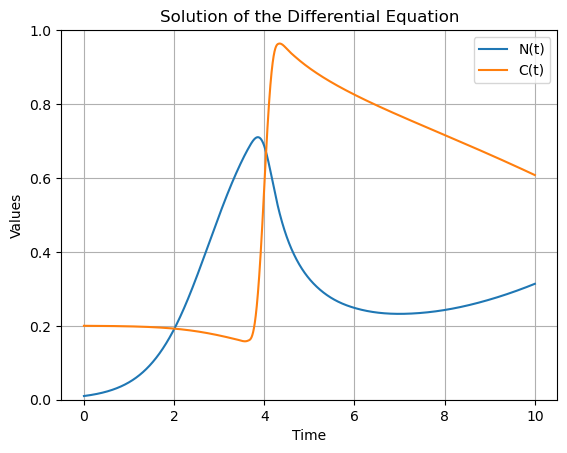

In [128]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C) + injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return 2*N

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
numevals = 2**17
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.2],t_eval=evalpts,args=(trueAlpha,))
plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()


131072 data points
(N)' = 2.001 N + -1.986 N^2 + -2.001 N C + -0.035 N^3 + 0.054 N^2 C + -0.051 N C^2 + 0.011 C^3
(C)' = 0.629 1 + -1.000 N + -4.285 C + -7.601 N^2 + 12.720 N C + 4.925 C^2 + 5.877 N^3 + 19.209 N^2 C + -23.760 N C^2 + 1.030 C^3
Model score: 0.995856


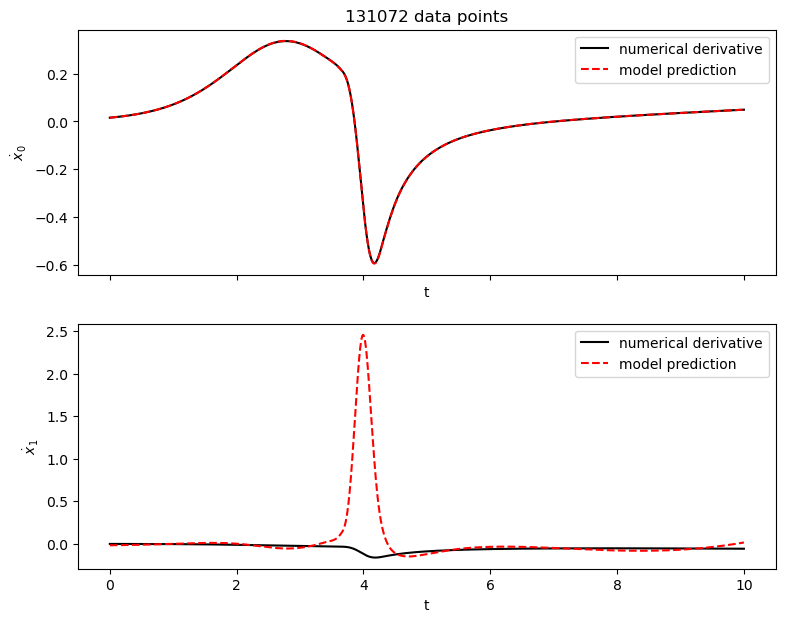

In [54]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [0]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.1, alpha=500)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-2),feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()

In [115]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C) + injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return 2*N

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
numevals = 2**10
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.2],t_eval=evalpts,args=(trueAlpha,))


131072 data points
(N)' = 1.996 N + -1.987 N^2 + -1.977 N C + -0.016 N^3 + -0.012 N^2 C + -0.022 N C^2
(C)' = 0.633 1 + -1.006 N + -4.311 C + -7.594 N^2 + 12.736 N C + 4.970 C^2 + 5.873 N^3 + 19.209 N^2 C + -23.773 N C^2 + 1.007 C^3
Model score: 0.995880


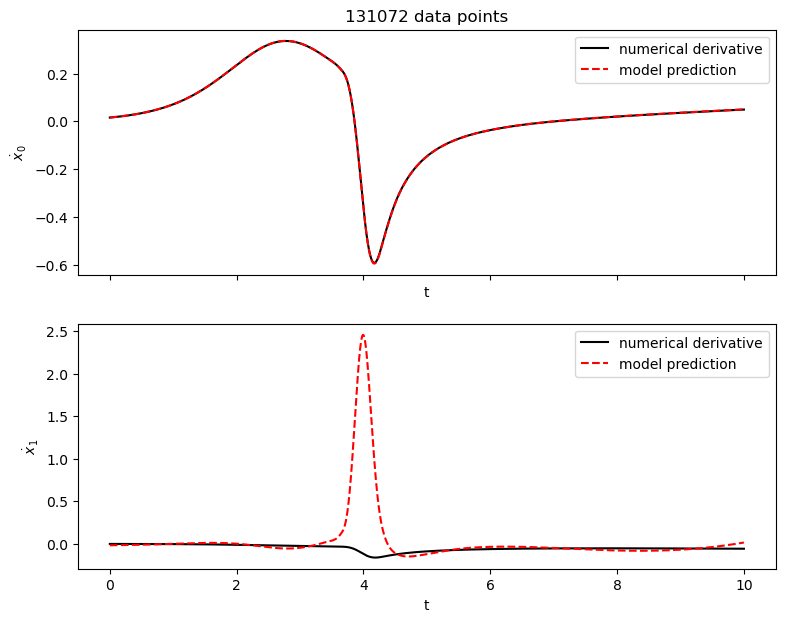

In [112]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [0]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.1, alpha=50)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-5),feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()

16384 data points
(N)' = 1.996 N + -1.986 N^2 + -1.976 N C + -0.017 N^3 + -0.011 N^2 C + -0.023 N C^2
(C)' = 0.135 N + -8.462 N^2 + 7.378 N C + -1.799 C^2 + 5.861 N^3 + 22.793 N^2 C + -21.779 N C^2 + 4.630 C^3
Model score: 0.995344


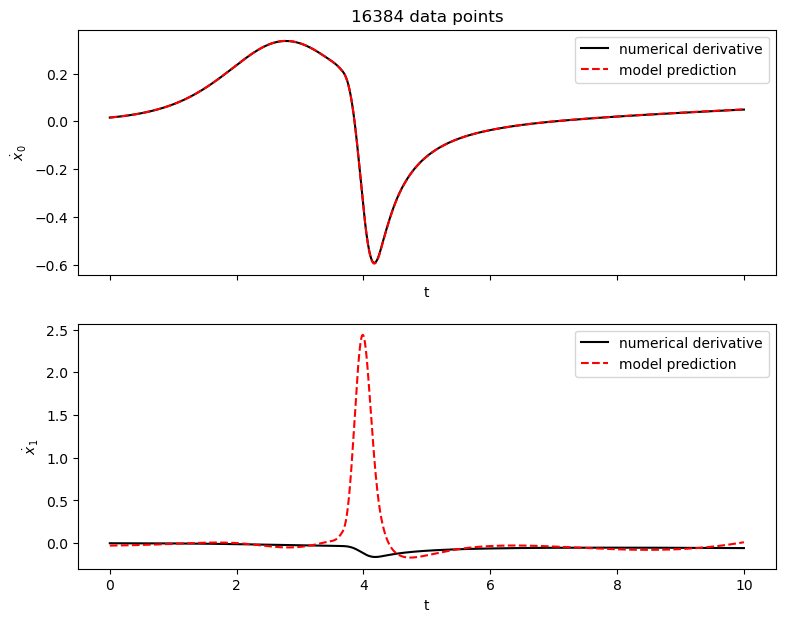

In [114]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [0]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.1, alpha=0.5)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-5),feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()

1024 data points
(N)' = 1.996 N + -1.977 N^2 + -1.987 N C + -0.043 N^3 + 0.049 N^2 C + -0.061 N C^2 + 0.010 C^3
(C)' = 0.634 1 + -0.999 N + -4.315 C + -7.608 N^2 + 12.715 N C + 4.982 C^2 + 5.883 N^3 + 19.225 N^2 C + -23.765 N C^2 + 1.000 C^3
Model score: 0.995887


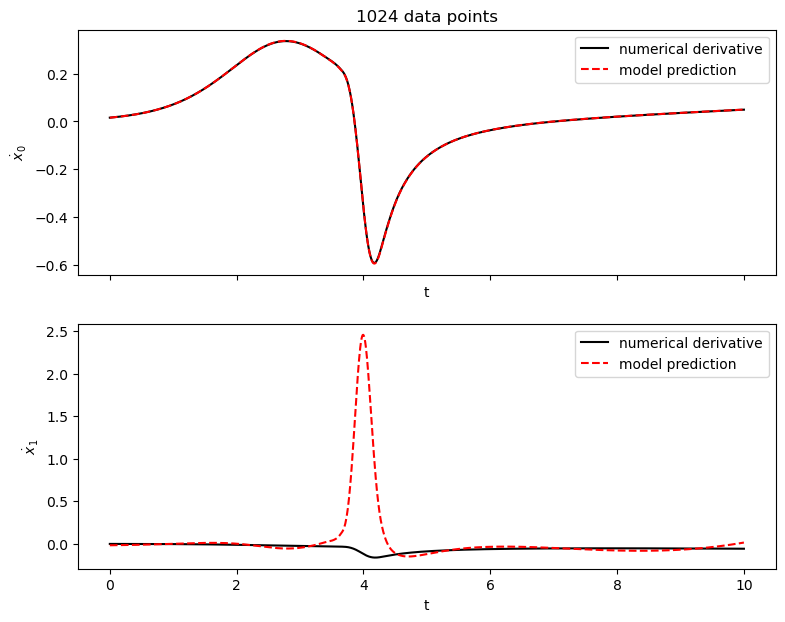

In [118]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [0]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.1, alpha=5)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-5),feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()

512 data points
(N)' = 1.718 N + -0.751 N^2 + -1.669 N C + -2.167 N^3 + 2.889 N^2 C + -2.432 N C^2 + 0.402 C^3
(C)' = -0.036 1 + -0.657 N + 0.680 C + -7.637 N^2 + 11.207 N C + -4.371 C^2 + 5.810 N^3 + 19.883 N^2 C + -23.683 N C^2 + 6.513 C^3
Model score: 0.991537


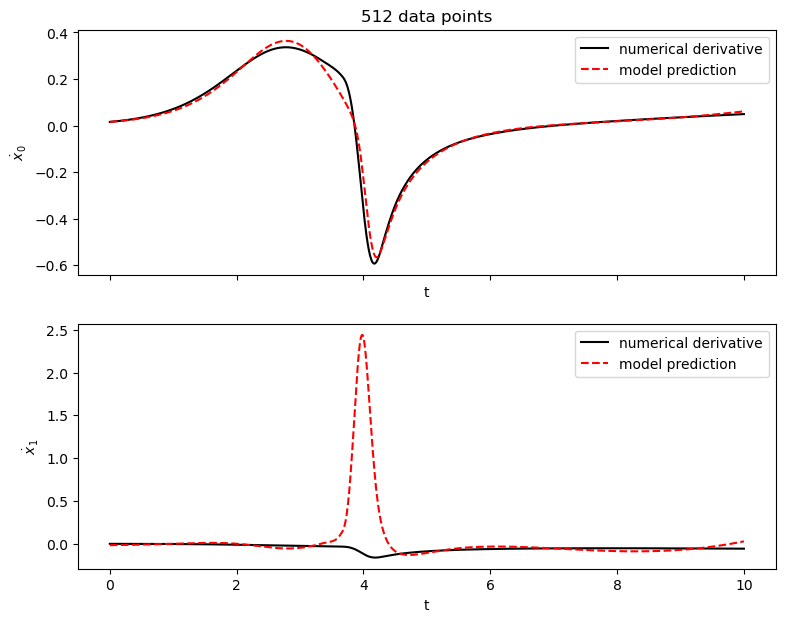

In [125]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [1]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.1, alpha=0.5)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-2),feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()

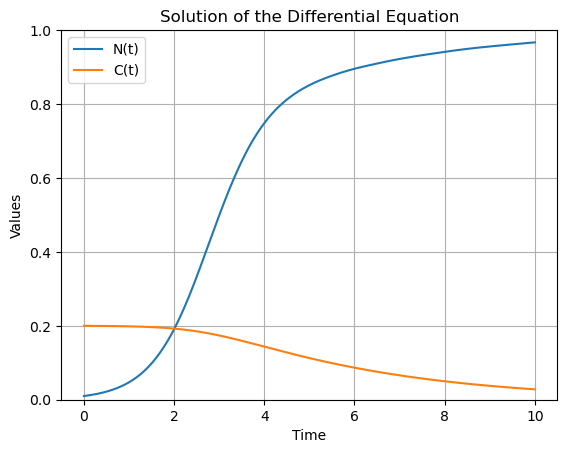

In [129]:
def g(N):
  return N*(1-N)

def gprime(N):
  return 1-2*N

injectionSpeed = 5
injectionStrength = 2.5
def fprime(t,state,alpha):
  N = state[0]
  C = state[1]
  return [alpha*g(N)-C*u(N),cprime(N,C)]# + injectionStrength*np.exp(-(injectionSpeed*(t-4))**2)]

def u(N):
  return 2*N

def uprime(N):
  return 1

gamma = 0.3
def cprime(N,C):
  return -gamma*N*C

trueAlpha = 2
final = 10
initial = 0
numevals = 2**10
evalpts = np.linspace(initial,final,numevals)
solution = solve_ivp(fprime,(0,10),[0.01,0.2],t_eval=evalpts,args=(trueAlpha,))

plt.plot(solution.t, solution.y[0], label='N(t)')
plt.plot(solution.t, solution.y[1], label='C(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.ylim(0,1)
plt.title('Solution of the Differential Equation')
plt.legend()
plt.grid(True)
plt.show()

1024 data points
(N)' = 1.999 N + -1.995 N^2 + -2.002 N C + -0.005 N^3
(C)' = 0.000
Model score: -1.082139


c:\Users\shale\miniconda3\envs\PINNsAndUPINNs\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


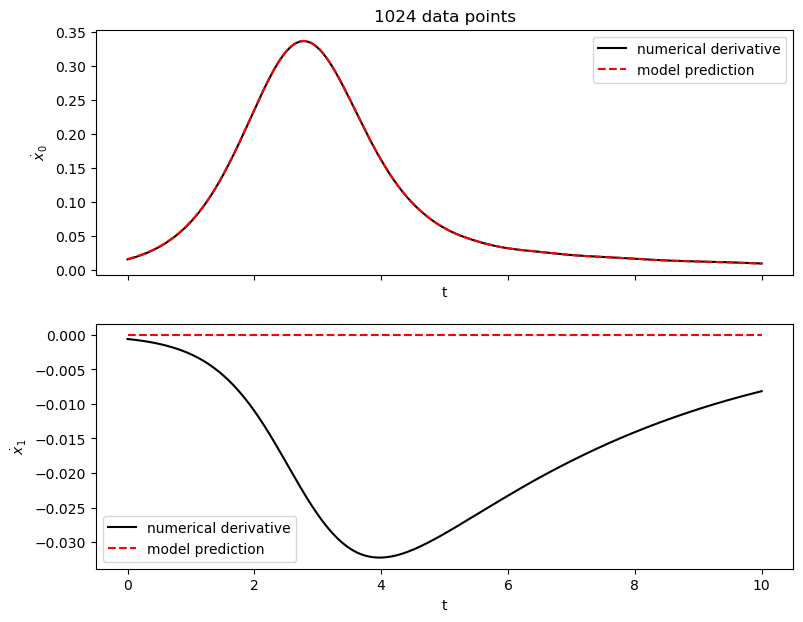

In [139]:
#numbersOfDatasetSplits = [0,1,2,3,4,5,6,7,8]

numbersOfDatasetSplits = [0]
for numDataSplits in numbersOfDatasetSplits:
  print(f"{(int)(numevals/(2**numDataSplits))} data points")

  

  #creating a list containing the indexes of t that specify that only (datasetlength/(2^numDataSplits)) points are used in training
  newIndexes = [(2**numDataSplits)*n for n in range((int)(np.shape(solution.t)[0]/(2**numDataSplits)))]

  X = solution.y[:,newIndexes].T

  optimizer = ps.STLSQ(threshold=0.1, alpha=5)#, max_iter=10000)

  #x_dot = np.array([trueAlpha*g(solution.y[0,newIndexes])-solution.y[1,newIndexes]*u(solution.y[0,newIndexes]),cprime(solution.y[0,newIndexes],solution.y[1,newIndexes])]).T
  
  poly_lib = ps.PolynomialLibrary(degree=3)

  model = ps.SINDy(differentiation_method=ps.SINDyDerivative(kind="spline", s=1e-5),feature_names=["N","C"],feature_library=poly_lib,optimizer=optimizer)
  model.fit(X, t=solution.t[newIndexes],)
  model.print()
  print("Model score: %f" % model.score(solution.y.T, t=solution.t))

  # Predict derivatives using the learned model
  x_dot_test_predicted = model.predict(solution.y.T)

  # Compute derivatives with a finite difference method, for comparison
  x_dot_test_computed = np.array([trueAlpha*g(solution.y[0])-solution.y[1]*u(solution.y[0]),cprime(solution.y[0],solution.y[1])]).T

  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

  for i in range(X.shape[1]):
    axs[i].plot(solution.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
    axs[i].plot(solution.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
  axs[0].set_title(f"{(int)(numevals/(2**numDataSplits))} data points")
  fig.show()
  
  fig.show()